In [1]:
import juliacall, juliatorch
import torch
import pyro.distributions as dist
from chirho.contrib.experiments.fishery.build_f import build_steady_state_f, build_temporal_f
import pyro
import pyro.distributions as dist
from collections import OrderedDict
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import seaborn as sns

/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preliminary Setup

In [2]:
# Define helpers that take fishing mortality rates, a parameter dict, and initial biomass, and flattens
#  everything into a single tensor that can be passed to a juliatorch JuliaFunction.
def flatten_for_steady_state(parameters, initial_biomass, fishing_mortality_rates):
    ps = parameters
    return torch.cat(
        [
            initial_biomass,
            torch.stack([
                ps["r1"],
                ps["k1"],
                ps["p12"],
                ps["d1"],
                fishing_mortality_rates[0],
                ps["r2"],
                ps["e12"],
                ps["p23"],
                ps["d2"],
                fishing_mortality_rates[1],
                ps["r3"],
                ps["e23"],
                ps["m3"],
                fishing_mortality_rates[2],
            ]).squeeze()
        ]
    )

def flatten_for_temporal(parameters, initial_biomass, fishing_mortality_rates, times):
    return torch.cat([flatten_for_steady_state(parameters, initial_biomass, fishing_mortality_rates), times])

In [3]:
# Construct the python function interface to the underlying julia solver
#  of the Zhou and Smith's fishery model (2017)
fishery_steady_state_solver = build_steady_state_f()
fishery_temporal_solver = build_temporal_f()

In [4]:
# Parameters used by Zhao and Smith (2017). We treat these as the true values.
TRUEVALS = OrderedDict(
    k1=1000.0, r1=2.0, r2=1.0, r3=0.25, p12=0.5, p23=0.5, d1=100.0, d2=10.0, e12=0.2, e23=0.2, m3=0.01
)
for k, v in TRUEVALS.items():
    TRUEVALS[k] = torch.tensor(v)

# Used to scale up approximately growth proportional fishing rates to absolute fishing rates.
# Note that these are fixed quantities serving only to transform 0-1 fishing rate parameters to absolute rates.
APPROX_GROWTH_RATES = torch.tensor([TRUEVALS["r1"], TRUEVALS["r2"], TRUEVALS["r3"]])

In [5]:
# Approximate equilibrium biomass for the unfished case.
B_UNFISHED = torch.tensor([958.833, 174.356, 33.476])

In [6]:
def fishery_steady_state(parameters, initial_biomass, fishing_mortality_rates):
    return fishery_steady_state_solver(flatten_for_steady_state(parameters, initial_biomass, fishing_mortality_rates))

def fishery_at_times(parameters, initial_biomass, fishing_mortality_rates, times):
    return fishery_temporal_solver(flatten_for_temporal(parameters, initial_biomass, fishing_mortality_rates, times))

### Exploitative Fishing

The narrative begins with exploitative fishing that only considers the maximum sustainable revenue (MSR). For simplicity here, we assume the true parameters are known, and the MSR policy is identified based on those parameters. This policy runs for a number of years, and the biomass is noisily observed at the end of each year.

In [7]:
# Define we dub the maximum sustainable revenue, assuming fixed market prices.
PRICES = torch.tensor([1.0, 20.0, 100.0])

def gross_revenue(biomass, mortality, prices):
    return (biomass * mortality * prices).sum()

In [8]:
# Use scipy optimize and the true parameter values to find the MSR fishing rates.
def find_msr_fishing_rates(truevals, initial_biomass, prices):
    def objective(mortality_proportions: np.ndarray):
        mortality_rates = torch.tensor(mortality_proportions) * APPROX_GROWTH_RATES
        ss = fishery_steady_state(truevals, initial_biomass, mortality_rates)
        msr = gross_revenue(ss, mortality_rates, prices).sum()
        return -msr

    return optimize.minimize(objective, x0=np.array([0.1, 0.1, 0.1]), bounds=[(0.0, 1.0)] * 3).x

In [9]:
msr_rates = torch.tensor(find_msr_fishing_rates(TRUEVALS, B_UNFISHED, PRICES)) * APPROX_GROWTH_RATES

In [10]:
# Plot the biomass over time under the MSR policy.
expl_times = torch.arange(0, 5, 0.5)
expl_biomass_at_times = fishery_at_times(TRUEVALS, B_UNFISHED, msr_rates, expl_times)

In [11]:
def plot_biomass_over_time(times, biomass_at_times, logscale=True, show=True):
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(times, biomass_at_times[0], label="Forage")
    ax.plot(times, biomass_at_times[1], label="Intermediate")
    ax.plot(times, biomass_at_times[2], label="Apex", color="g")
    if logscale:
        ax.set_yscale("log")
    ax.set_ylabel("Biomass")
    ax.set_xlabel("Time")
    ax.legend()
    if show:
        plt.show()
    return fig, ax

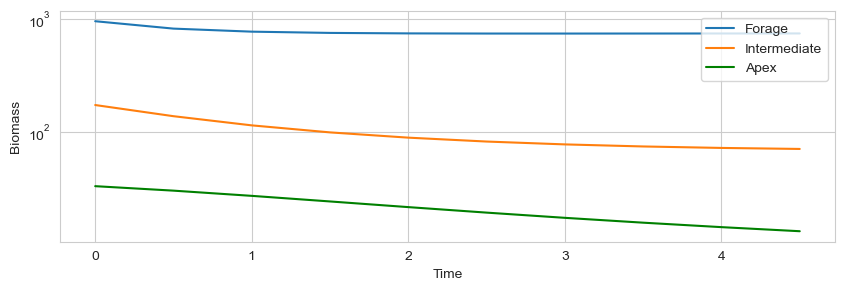

(<Figure size 1000x300 with 1 Axes>, <Axes: xlabel='Time', ylabel='Biomass'>)

In [12]:
plot_biomass_over_time(expl_times, expl_biomass_at_times)

### Pause on Fishing

The exploitative period ended after concerns developed around the downspin in apex predator numbers. The fishery is paused for a period of time, and the biomass is observed with more frequency.

In [13]:
pause_times = torch.arange(0.1, 1, 0.1)
pause_biomass_at_times = fishery_at_times(TRUEVALS, expl_biomass_at_times[:, -1], torch.zeros_like(msr_rates), pause_times)

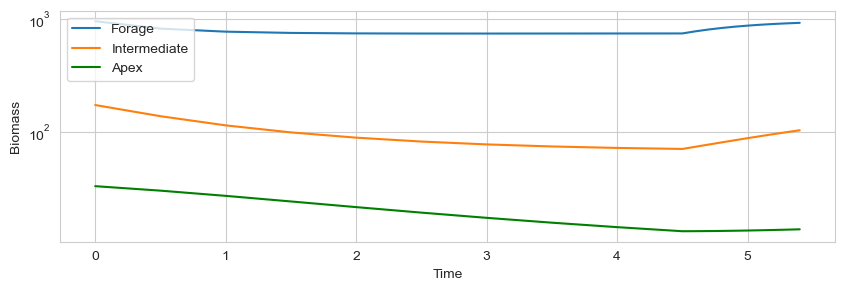

(<Figure size 1000x300 with 1 Axes>, <Axes: xlabel='Time', ylabel='Biomass'>)

In [14]:
expl_and_pause_times = torch.cat([expl_times, expl_times[-1] + pause_times])
expl_and_pause_biomass_at_times = torch.cat([expl_biomass_at_times, pause_biomass_at_times], dim=1)
plot_biomass_over_time(expl_and_pause_times, expl_and_pause_biomass_at_times)

### Ecologically Aware Fishing

After a few years of exploitative fishing, ecological concerns begin to take more prominence. Our task is to take a high level understanding of fishery parameters (our "prior") and combine that with observed data during the exploitative period. We then seek a new set of fishing rates that also optimize for biodiversity and avoid rare, but catostrophic extinction events.  

#### Prior Definition
TODO port over details from julia file.

In [15]:
# Define prior over parameters of fishery. 
def prior():
    k1 = pyro.sample("k1", dist.LogNormal(loc=6.94, scale=0.18))
    r1 = pyro.sample("r1", dist.LogNormal(loc=0.76, scale=0.59))
    r2 = pyro.sample("r2", dist.LogNormal(loc=0.0, scale=0.42))
    r3 = pyro.sample("r3", dist.LogNormal(loc=-1.3, scale=0.79))
    p12 = pyro.sample("p12", dist.LogNormal(loc=-0.70, scale=1.1))
    p23 = pyro.sample("p23", dist.LogNormal(loc=-0.70, scale=1.1))
    d1 = pyro.sample("d1", dist.LogNormal(loc=4.61, scale=0.42))
    d2 = pyro.sample("d2", dist.LogNormal(loc=2.30, scale=0.42))
    e12 = pyro.sample("e12", dist.LogNormal(loc=-1.97, scale=0.37))
    e23 = pyro.sample("e23", dist.LogNormal(loc=-1.97, scale=0.37))
    m3 = pyro.sample("m3", dist.LogNormal(loc=-4.232, scale=0.6))
    
    return OrderedDict(
        k1=k1, r1=r1, r2=r2, r3=r3, p12=p12, p23=p23, d1=d1, d2=d2, e12=e12, e23=e23, m3=m3
    )

In [16]:
# Plot the marginals for each parameter, alongisde the approximate lower and upper bounds, and the median.
def plot_marginals(samples, truevals=None):
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    for i, (name, samples_one_var) in enumerate(samples.items()):
        ax = axs[i // 4, i % 4]
        sns.kdeplot(samples_one_var, ax=ax)
        ax.axvline(torch.median(samples_one_var), color="r", linestyle="--", linewidth=0.1)
        sq = torch.quantile(samples_one_var, 0.025)
        ax.axvline(sq, color="r", linestyle="--", linewidth=0.3)
        lq = torch.quantile(samples_one_var, 0.975)
        ax.axvline(lq, color="r", linestyle="--", linewidth=0.3)
        ax.set_title(name)
        ax.grid(False)
        if truevals is not None:
            ax.axvline(truevals[name], color="k", linestyle="--")
        ax.set_xlim(0.0, lq*1.5)
    plt.tight_layout()
    return fig, axs

/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

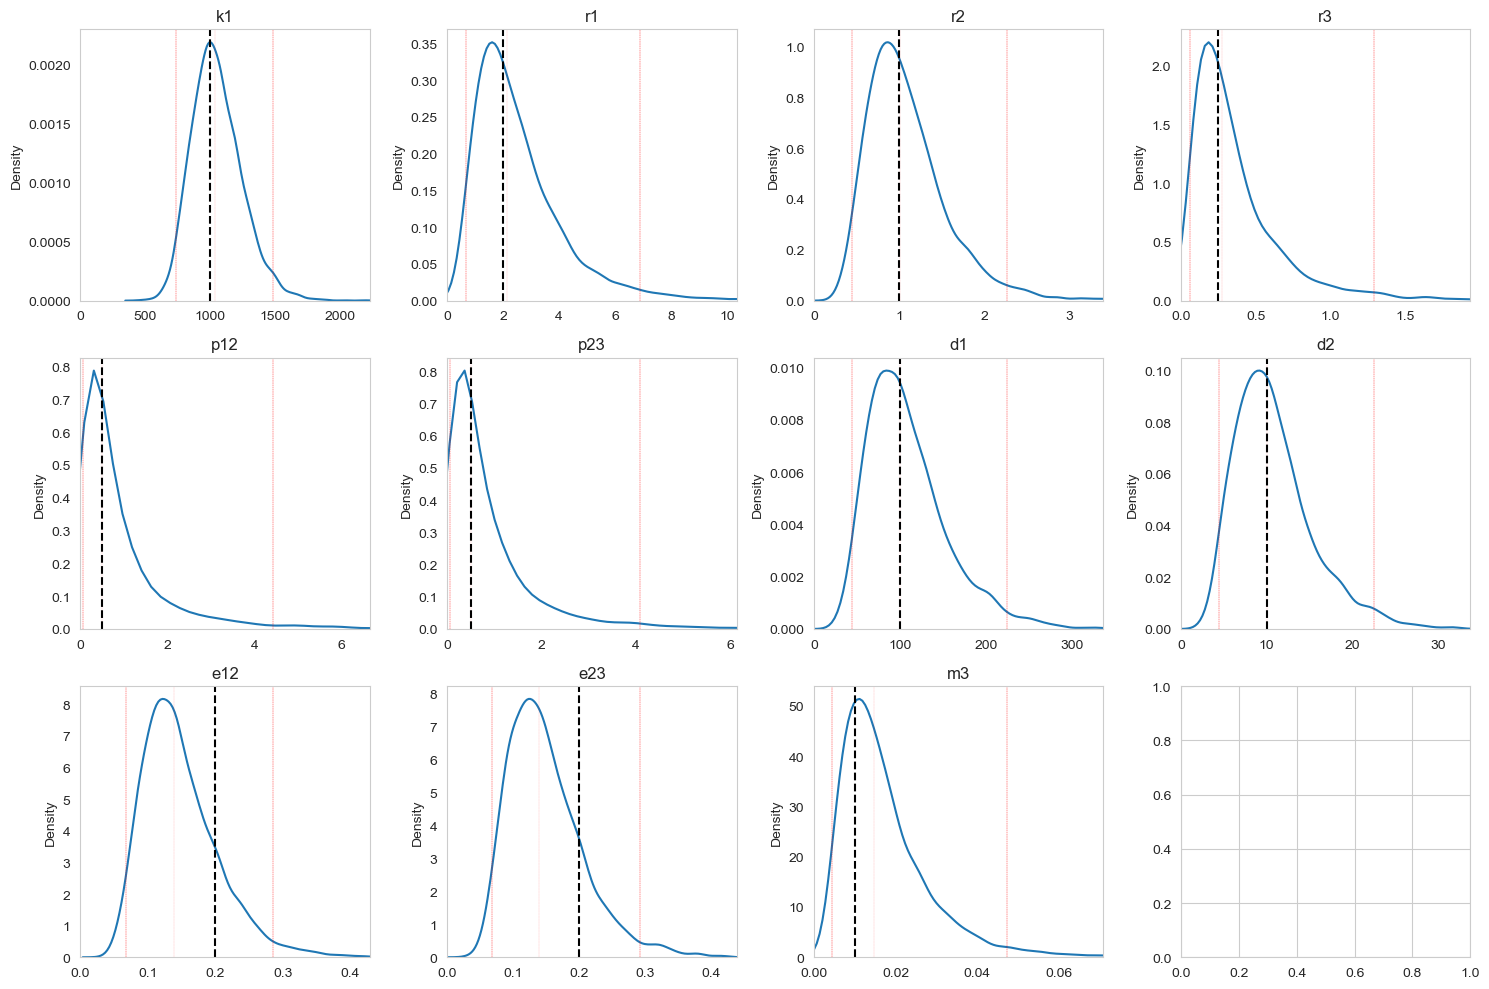

In [17]:
# Sample from the prior
with pyro.plate("samples", 5000):
    plot_marginals(prior(), TRUEVALS)
plt.show()

#### Observation Noise
Realistically, biomass measurements are noisy. We posit a simple roughly 20% relative error in biomass measurements for each trophic level. In reality, of course, this might differ across strata. 

In [18]:
def lognormal_parameters(mu, sigma):
    sigma_log = torch.log(sigma ** 2. / mu ** 2. + 1.0)
    mu_log = torch.log(mu) - 0.5 * sigma_log
    return mu_log, sigma_log

def observation_model(biomass_at_times, obs_str="obs"):
    # Use lognormals just to fold in the positivity constraints.
    unscaled_noise = 0.5
    sigma = (biomass_at_times ** 0.9) * unscaled_noise
    
    mu_log, sigma_log = lognormal_parameters(biomass_at_times, sigma)
    
    return pyro.sample(obs_str, dist.LogNormal(mu_log, sigma_log))

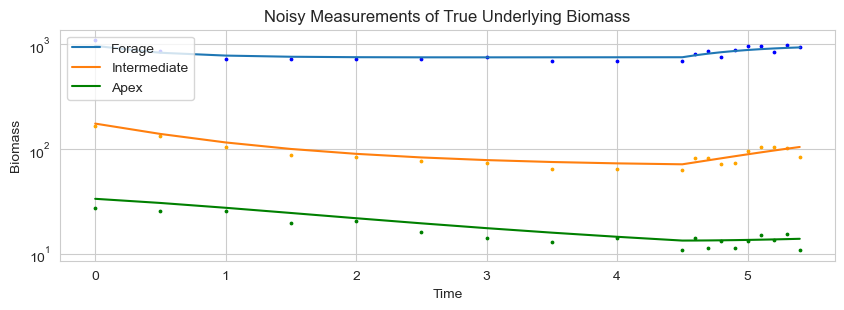

In [19]:
fig, ax = plot_biomass_over_time(expl_and_pause_times, expl_and_pause_biomass_at_times, show=False)

# Plot biomass measurement points.
observed_biomass_at_times = observation_model(expl_and_pause_biomass_at_times)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[0], color="b", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[1], color="orange", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[2], color="g", s=3.)
ax.set_title("Noisy Measurements of True Underlying Biomass")
plt.show()

#### Stiching the Model Together
Thus far we've defined a prior, two fishing regimes, and an observation model. We can now stitch these together into a full model. We additionally add prior uncertainty over the initial biomass.

In [20]:
def initial_biomass():
    mu_log, sigma_log = lognormal_parameters(B_UNFISHED, 0.5 * B_UNFISHED)
    return pyro.sample("initial_biomass", dist.LogNormal(loc=mu_log, scale=sigma_log))

def prior_predictive_fishery_model():
    parameters = prior()
    biomass0 = initial_biomass()
    
    # Exploitative period.
    expl_x = flatten_for_temporal(parameters, biomass0, msr_rates, expl_times)
    expl_mean_y = fishery_temporal_solver(expl_x)
    
    # Pause period.
    pause_x = flatten_for_temporal(parameters, expl_mean_y[:, -1], torch.zeros_like(msr_rates), pause_times)
    pause_mean_y = fishery_temporal_solver(pause_x)
    
    return expl_mean_y, pause_mean_y
    
def full_observed_fishery_model():
    expl_mean_y, pause_mean_y = prior_predictive_fishery_model()
    
    expl_obs_y = observation_model(expl_mean_y, "expl_obs")
    pause_obs_y = observation_model(pause_mean_y, "pause_obs")
    
    return expl_obs_y, pause_obs_y, expl_mean_y, pause_mean_y

#### Visualize Prior Predictive

In [21]:
# Visualize the full model. It should look roughly like what we've plotted above.
obs_expl_biomass_at_times_list, obs_pause_biomass_at_times_list = [], []
mean_expl_biomass_at_times_list, mean_pause_biomass_at_times_list = [], []
for _ in range(1000):
    obs_expl_biomass_at_times, obs_pause_biomass_at_times, mean_expl_biomass_at_times, mean_pause_biomass_at_times = full_observed_fishery_model()
    obs_expl_biomass_at_times_list.append(obs_expl_biomass_at_times)
    obs_pause_biomass_at_times_list.append(obs_pause_biomass_at_times)
    mean_expl_biomass_at_times_list.append(mean_expl_biomass_at_times)
    mean_pause_biomass_at_times_list.append(mean_pause_biomass_at_times)

obs_expl_biomass_at_times = torch.stack(obs_expl_biomass_at_times_list)
obs_pause_biomass_at_times = torch.stack(obs_pause_biomass_at_times_list)
mean_expl_biomass_at_times = torch.stack(mean_expl_biomass_at_times_list)
mean_pause_biomass_at_times = torch.stack(mean_pause_biomass_at_times_list)

In [22]:
obs_expl_and_pause_biomass_at_times = torch.cat([obs_expl_biomass_at_times, obs_pause_biomass_at_times], dim=-1)
mean_expl_and_pause_biomass_at_times = torch.cat([mean_expl_biomass_at_times, mean_pause_biomass_at_times], dim=-1)

# Get 0.05, 0.5, and 0.95 quantiles for each time point, so we can plot CIs.
obs_expl_and_pause_biomass_at_times_q = torch.quantile(obs_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)
mean_expl_and_pause_biomass_at_times_q = torch.quantile(mean_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)


In [23]:
def plot_biomass_over_time_with_ci(times, biomass_at_times_q, logscale=True, show=True):
    fig, ax = plot_biomass_over_time(times, biomass_at_times_q[1], logscale, False)
    for i in range(3):
        ax.fill_between(times, biomass_at_times_q[0, i], biomass_at_times_q[2, i], alpha=0.3)
    if show:
        plt.show()
    return fig, ax

Text(0.5, 1.0, '5th and 95th Prior Predictive Marginal Percentiles of Underlying Biomass')

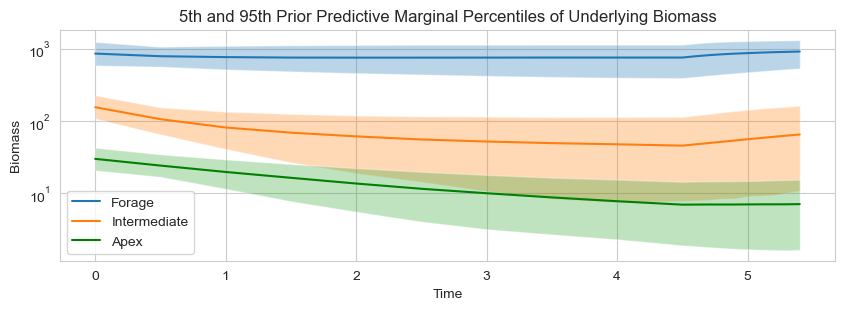

In [24]:
_, ax_ = plot_biomass_over_time_with_ci(expl_and_pause_times, mean_expl_and_pause_biomass_at_times_q, show=False)
ax_.set_title("5th and 95th Prior Predictive Marginal Percentiles of Underlying Biomass")

Text(0.5, 1.0, '5th and 95th Prior Predictive Marginal Percentiles of Noisy Biomass Measurements')

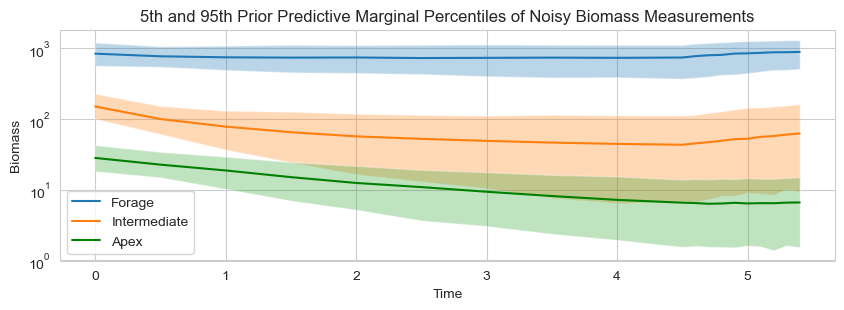

In [25]:
_, ax_ = plot_biomass_over_time_with_ci(expl_and_pause_times, obs_expl_and_pause_biomass_at_times_q, show=False)
ax_.set_title("5th and 95th Prior Predictive Marginal Percentiles of Noisy Biomass Measurements")

#### Posterior Inference
Traditional multi-stage approaches run posterior inference first. We'll find that useful here just to see what kind of information available data can provide about our parameters. 